In [1]:
import tensorflow as tf
import numpy as np
import scipy.io  
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import errno
import xml.etree.cElementTree as ET


In [2]:
VERBOSE = 0
ANCHOR_K = 9
NET_OUT_CHANNEL = 512

In [3]:
###1、读图 2、显示图片 3、预处理缩放 4、读取标注信息

In [4]:
def read_img(path,data_name):
    path = os.path.join(path,'img',data_name+'.jpg')
    img = cv2.imread(path, cv2.IMREAD_COLOR) #cv读图更快一些，但是是bgr排布
    if img is None:
        raise OSError(errno.ENOENT, "No such file", path)
    img = img.astype(np.float32)
    img,scale = preprocess(img)
    return img,scale

def show_img(img,loc_box,label,score):
    #img : 输入图像数据
    #loc_box : box位置信息，（n，4）的矩阵，4对应四个参数为（左上点x，左上y，右下x，右下y）
    #label ： 每个box的标签
    #score ： 每个标签的可行度
    img = img.astype(np.uint8)
    plt.imshow(img)
    for i,bb in enumerate(loc_box):
        x = bb[0]
        y = bb[1]
        width = bb[2]-bb[0]
        height = bb[3]- bb[1]
        plt.gca().add_patch(plt.Rectangle((x, y),width,height, 
                                      fill=False,edgecolor='r', linewidth=3))
        plt.text(x, y,VOC_BBOX_LABEL_NAMES[label[i]]+":"+str(score[i]),color = "b",style='italic',
                    bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})
    plt.axis('off') # 不显示坐标轴
    plt.show()

def preprocess(img):
    img = img[...,::-1]#bgr to rgb
    h,w,d = img.shape
    min_size = 600
    max_size = 1000
    scale1 = min_size / min(h, w)
    scale2 = max_size / max(h, w)
    scale = min(scale1, scale2)
    if VERBOSE:
        print("img shape is ",img.shape)
        print("scale is",scale)
    img = cv2.resize(img, dsize=(int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    if VERBOSE: print("after resize img shape is ",img.shape)
    #适配conv2d input参数[batch_size,h,w,channels]
    img = img[np.newaxis,:,:,:]
    return img,scale

def read_image_info(path,img_name):
    anno = ET.parse(os.path.join(path, 'Annotations', img_name + '.xml'))
    bbox = list()
    label = list()
    difficult = list()
    for obj in anno.findall('object'):
        #跳过diffcult图片
        #if int(obj.find('difficult').text) == 1:
        #    continue
        difficult.append(int(obj.find('difficult').text))
        bndbox_anno = obj.find('bndbox')
        # subtract 1 to make pixel indexes 0-based
        bbox.append([int(bndbox_anno.find(tag).text)-1 for tag in ('xmin', 'ymin', 'xmax', 'ymax')])
        name = obj.find('name').text.lower().strip()
        label.append(VOC_BBOX_LABEL_NAMES.index(name))
    bbox = np.stack(bbox).astype(np.float32)
    label = np.stack(label).astype(np.int32)
    difficult = np.array(difficult, dtype=np.bool).astype(np.uint8) #可以不用diff cult的图片分类 
    return bbox,label

def get_img_sample(path,img_name):
    ###split = ['train','trainval','val']
    #读取Segmentation目录下，对应split.txt文件中的第img_num个图片
    #输出img、bbox位置，label标签，scale缩放洗漱
    bbox = list()
    label = list()
    img = list()
    scale = list()
    bbox,label= read_image_info(path,img_name)
    img,scale = read_img(path,img_name)
    bbox = bbox *scale
    bbox = np.stack(bbox).astype(np.float32)
    label = np.stack(label).astype(np.int32)
    img = np.stack(img).astype(np.float32)
    return img,bbox,label,scale

In [5]:
VOC_BBOX_LABEL_NAMES = (
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor')


In [6]:
###3加载VGG模型参数

In [7]:
def load_net_para(path):
    vgg_wrap = scipy.io.loadmat(path)
    vgg_para = vgg_wrap['params'][0]
    return vgg_para

def get_weights(vgg_para, layer_num,layer_name=None,trainEn=True):
    weights = vgg_para[layer_num*2][1]
    #W = tf.constant(weights)
    W = tf.Variable(initial_value=weights,trainable=trainEn,name=layer_name)
    if VERBOSE : print("layer name is:",vgg_para[layer_num*2][0],layer_num,"layer weights shape :",W.shape)
    return W

def get_bias(vgg_para, layer_num,layer_name=None,trainEn=True):
    bias = vgg_para[layer_num*2+1][1]
    b = tf.Variable(initial_value=np.reshape(bias, (bias.size)),trainable=trainEn,name=layer_name)
    #b = tf.constant(np.reshape(bias, (bias.size)))
    if VERBOSE : print("layer name is:",vgg_para[layer_num*2+1][0],layer_num,"layer bias shape :",b.shape)
    return b

In [8]:
###VGG 提取图像特征

In [9]:
def conv_layer(layer_name, layer_input, W):
    conv = tf.nn.conv2d(layer_input, W, strides=[1, 1, 1, 1], padding='SAME')
    if VERBOSE:
        print('--{} | shape={} | layer_input={} | weights_shape={}'.format(layer_name, conv.shape(),layer_input.shape(), W.shape()))
    return conv

def relu_layer(layer_name, layer_input, b):
    relu = tf.nn.relu(layer_input + b)
    if VERBOSE: 
        print('--{} | shape={} | bias_shape={}'.format(layer_name, relu.shape(), b.shape()))
    return relu

def pool_layer(layer_name, layer_input):
    pool = tf.nn.max_pool(layer_input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    if VERBOSE: 
        print('--{}   | shape={}'.format(layer_name, pool.get_shape()))
    return pool

def extra_feature(img):   
    if VERBOSE: print('loading model weights...')
    vgg_layers = load_net_para("fast-rcnn-vgg16-pascal07-dagnn.mat")
    
    if VERBOSE: print('constructing layers...')
    if VERBOSE: print('LAYER GROUP 1')
    
    ####################VGG-16################
    #net['input'] = img
    
    x = conv_layer('conv1_1', img, W=get_weights(vgg_layers, 0,layer_name='vggconv1_1',trainEn=False))
    x = relu_layer('relu1_1', x, b=get_bias(vgg_layers, 0,layer_name='vggrelu1_1',trainEn=False))

    x = conv_layer('conv1_2', x, W=get_weights(vgg_layers, 1,layer_name='vggconv1_2',trainEn=False))
    x = relu_layer('relu1_2', x, b=get_bias(vgg_layers, 1,layer_name='vggrelu1_2',trainEn=False))

    x   = pool_layer('pool1', x)

    if VERBOSE: print('LAYER GROUP 2')  
    x = conv_layer('conv2_1', x, W=get_weights(vgg_layers, 2,layer_name='vggconv2_1',trainEn=False))
    x = relu_layer('relu2_1', x, b=get_bias(vgg_layers, 2,layer_name='vggrelu2_1',trainEn=False))

    x = conv_layer('conv2_2', x, W=get_weights(vgg_layers, 3,layer_name='vggconv2_2',trainEn=False))
    x = relu_layer('relu2_2', x, b=get_bias(vgg_layers, 3,layer_name='vggrelu2_2',trainEn=False))

    x   = pool_layer('pool2', x)

    if VERBOSE: print('LAYER GROUP 3')
    x = conv_layer('conv3_1', x, W=get_weights(vgg_layers, 4,layer_name='vggconv3_1',trainEn=False))
    x = relu_layer('relu3_1', x, b=get_bias(vgg_layers, 4,layer_name='vggrelu3_1',trainEn=False))

    x = conv_layer('conv3_2', x, W=get_weights(vgg_layers, 5,layer_name='vggconv3_2',trainEn=False))
    x = relu_layer('relu3_2', x, b=get_bias(vgg_layers, 5,layer_name='vggrelu3_2',trainEn=False))

    x = conv_layer('conv3_3', x, W=get_weights(vgg_layers, 6,layer_name='vggconv3_3',trainEn=False))
    x = relu_layer('relu3_3', x, b=get_bias(vgg_layers, 6,layer_name='vggrelu3_3',trainEn=False))

    x   = pool_layer('pool3', x)

    if VERBOSE: print('LAYER GROUP 4')
    x = conv_layer('conv4_1', x, W=get_weights(vgg_layers, 7,layer_name='vggconv4_1',trainEn=True))
    x = relu_layer('relu4_1', x, b=get_bias(vgg_layers, 7,layer_name='vggrelu4_1',trainEn=True))

    x = conv_layer('conv4_2', x, W=get_weights(vgg_layers, 8,layer_name='vggconv4_2',trainEn=True))
    x = relu_layer('relu4_2', x, b=get_bias(vgg_layers, 8,layer_name='vggrelu4_2',trainEn=True))

    x = conv_layer('conv4_3', x, W=get_weights(vgg_layers, 9,layer_name='vggconv4_3',trainEn=True))
    x = relu_layer('relu4_3', x, b=get_bias(vgg_layers, 9,layer_name='vggrelu4_3',trainEn=True))
    x   = pool_layer('pool4', x)

    if VERBOSE: print('LAYER GROUP 5')
    x = conv_layer('conv5_1', x, W=get_weights(vgg_layers, 10,layer_name='vggconv5_1',trainEn=True))
    x = relu_layer('relu5_1', x, b=get_bias(vgg_layers, 10,layer_name='vggrelu5_1',trainEn=True))

    x = conv_layer('conv5_2', x, W=get_weights(vgg_layers, 11,layer_name='vggconv5_2',trainEn=True))
    x = relu_layer('relu5_2', x, b=get_bias(vgg_layers, 11,layer_name='vggrelu5_2',trainEn=True))

    x = conv_layer('conv5_3', x, W=get_weights(vgg_layers, 12,layer_name='vggconv5_3',trainEn=True))
    x = relu_layer('relu5_3', x, b=get_bias(vgg_layers, 12,layer_name='vggrelu5_3',trainEn=True))
    feature = x
    
    ####################  RPN ################
    F_C = NET_OUT_CHANNEL
    conv_weights = tf.Variable(initial_value=tf.truncated_normal(shape=[3,3,F_C,F_C],stddev=0.01),name="rpn_weight1_1")        
    cls_weights = tf.Variable(initial_value=tf.truncated_normal(shape=[1, 1, F_C, ANCHOR_K*2],stddev=0.01),
                              name="rpn_weight_cls")
    rgr_weights = tf.Variable(initial_value=tf.truncated_normal(shape=[1, 1, F_C, ANCHOR_K*4],stddev=0.01),
                              name="rpn_weight_rgr")
    conv_biases = tf.Variable(initial_value=tf.constant(0,shape=[F_C],dtype=tf.float32),name="rpn_bias1_1")
    cls_biases  = tf.Variable(initial_value=tf.constant(0,shape=[ANCHOR_K*2],dtype=tf.float32),name="rpn_bias_cls")
    rgr_biases  = tf.Variable(initial_value=tf.constant(0,shape=[ANCHOR_K*4],dtype=tf.float32),name="rpn_bias_rgr")

    conv1_1 = tf.nn.conv2d(feature, conv_weights, strides=[1, 1, 1, 1], padding='SAME')
    relu1_1 = tf.nn.relu(tf.nn.bias_add(conv1_1, conv_biases))
    
    conv2_1 = tf.nn.conv2d(relu1_1, cls_weights, strides=[1, 1, 1, 1], padding='SAME')
    label_n_p  = tf.nn.relu(tf.nn.bias_add(conv2_1, cls_biases))
    
    conv2_2 = tf.nn.conv2d(relu1_1, rgr_weights, strides=[1, 1, 1, 1], padding='SAME')
    loc     = tf.nn.relu(tf.nn.bias_add(conv2_2, rgr_biases))
    rpn_label = tf.reshape(label_n_p,[-1,2]) # rpn_label[:,0]->负  rpn_label[:,1]->正
    rpn_loc = tf.reshape(loc,[-1,4])
    
    return feature,rpn_label,rpn_loc

img shape is  (500, 334, 3)
scale is 1.7964071856287425
after resize img shape is  (898, 600, 3)
[[123.952095 361.07785  456.28745  896.4072  ]
 [449.1018   432.93414  598.2036   896.4072  ]
 [  0.       256.88623  118.562874 781.43713 ]
 [  0.         0.       116.76647  650.29944 ]
 [131.13773    0.       486.82635  828.14374 ]
 [450.89822   32.33533  598.2036   873.0539  ]]


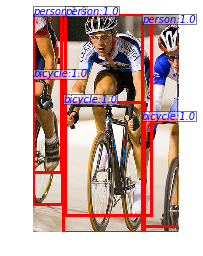

In [10]:
if __name__ == '__main__':
    img_input = tf.placeholder(tf.float32,shape=[1,None,None,3],name='img_input')
    train_path = os.path.join('data',"traindata","img")
    for i in range(1):
        list_num = os.listdir(train_path)
        img_name = list_num[i+10].strip().split('.')[0]
        img,bbox,label,scale =get_img_sample('data/traindata',img_name)
        print(bbox)
        show_img(img[0],bbox,label,np.ones(np.shape(label)))
    #feature = extra_feature(img)
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        #print (sess.run(feature,feed_dict={img_input:img}))

[1 2 3]
